### Задача

Провести базовый EDA выбранного набора данных (выбрать самостоятельно). 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from pylab import rcParams
rcParams['figure.figsize'] = 13,6

В качестве исходных данных я взяла датасет, представленный на kaggle (https://www.kaggle.com/mchirico/montcoalert), в котором собраны данные о звонках в экстренные службы округа Монтгомери, Пенсильвания, США.

In [4]:
data = pd.read_csv('911.csv')
data.head()

lat        lng                                               desc  \
0  40.297876 -75.581294  REINDEER CT & DEAD END;  NEW HANOVER; Station ...   
1  40.258061 -75.264680  BRIAR PATH & WHITEMARSH LN;  HATFIELD TOWNSHIP...   
2  40.121182 -75.351975  HAWS AVE; NORRISTOWN; 2015-12-10 @ 14:39:21-St...   
3  40.116153 -75.343513  AIRY ST & SWEDE ST;  NORRISTOWN; Station 308A;...   
4  40.251492 -75.603350  CHERRYWOOD CT & DEAD END;  LOWER POTTSGROVE; S...   

       zip                    title            timeStamp                twp  \
0  19525.0   EMS: BACK PAINS/INJURY  2015-12-10 17:10:52        NEW HANOVER   
1  19446.0  EMS: DIABETIC EMERGENCY  2015-12-10 17:29:21  HATFIELD TOWNSHIP   
2  19401.0      Fire: GAS-ODOR/LEAK  2015-12-10 14:39:21         NORRISTOWN   
3  19401.0   EMS: CARDIAC EMERGENCY  2015-12-10 16:47:36         NORRISTOWN   
4      NaN           EMS: DIZZINESS  2015-12-10 16:56:52   LOWER POTTSGROVE   

                         addr  e  
0      REINDEER CT & DEAD END  1  
1  BRIAR PATH & WHITEMARSH LN  1  
2                    HAWS AVE  1  
3          AIRY ST & SWEDE ST  1  
4    CHERRYWOOD CT & DEAD END  1

Описание столбцов:
- lat и lng - геокоординаты, широта и долгота
- desc - описание инцидента
- zip  - zip code - аналог почтового индекса в США
- title - вид (транспортное происшествие, пожар, обращение в скорую помощь и пр.) и краткое содержание инцидента
- timeStamp - время обращения
- twp - населенный пункт
- addr - адрес
- e - колонка индекс, всегда принимающая значение 1 

In [5]:
# последняя колонка не несет полезной информации для анализа, удалим её
data.drop('e', axis=1, inplace=True)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 663522 entries, 0 to 663521
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   lat        663522 non-null  float64
 1   lng        663522 non-null  float64
 2   desc       663522 non-null  object 
 3   zip        583323 non-null  float64
 4   title      663522 non-null  object 
 5   timeStamp  663522 non-null  object 
 6   twp        663229 non-null  object 
 7   addr       663522 non-null  object 
dtypes: float64(3), object(5)
memory usage: 40.5+ MB


In [6]:
# проверим на наличие пропусков

print('Пропущенные значения:', data.isnull().values.sum())
data.isnull().sum()


Пропущенные значения: 80492


lat              0
lng              0
desc             0
zip          80199
title            0
timeStamp        0
twp            293
addr             0
dtype: int64

In [7]:
# в процентах
for col in data.columns:
    pct_missing = np.mean(data[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

lat - 0%
lng - 0%
desc - 0%
zip - 12%
title - 0%
timeStamp - 0%
twp - 0%
addr - 0%


Пропуски есть в столбцах населенный пункт и zip код. Пропусков в столбце twp настолько мало (293 из 663522 строк), что мы можем удалить эти строки без заметных потерь. В столбце zip пропусков намного больше, просто удалять эти строки не следует. Однако мы можем выдвинуть ряд предположений, для которых наличие или отсутствие почтового индекса не критично. Например, в какие месяцы или дни недели совершается больше всего звонков; какие причины вызовов самые частые; из каких городов поступает наибольшее количество звонков. Поэтому обрабатывать пропуски в zip я не буду

In [54]:
# удаляем строки с пропусками в стобце населенный пункт
data.dropna(subset=['twp'], inplace=True)
data.isnull().sum()

lat              0
lng              0
desc             0
zip          80030
title            0
timeStamp        0
twp              0
addr             0
dtype: int64

<AxesSubplot:xlabel='Township', ylabel='Count'>

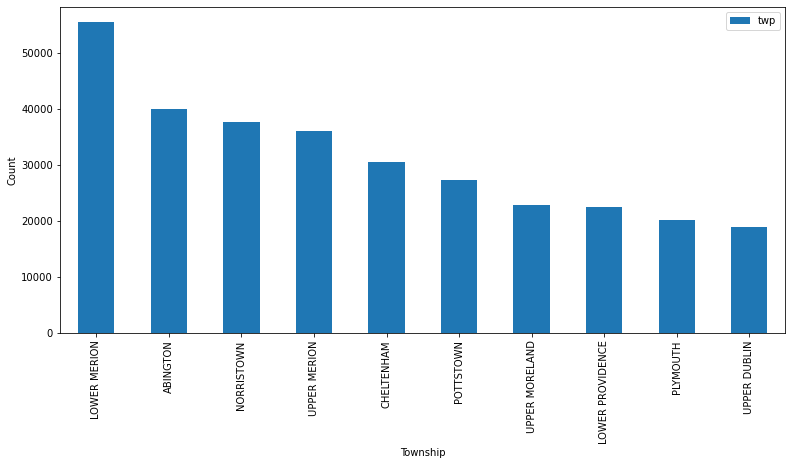

In [9]:
# посмотрим топ-10 населенных пунктов, откуда исходило больше всего звонков за все время
pd.DataFrame(data['twp'].value_counts().head(10)).plot(kind='bar', xlabel='Township', ylabel='Count')

Из населенного пункта Lower Merion поступило больше всего звонков. Можно предположить, что, во-первых, он достаточно большой по сравнению с остальными городами округа (возможно не самый густо населенный, но один из таковых), во-вторых, там могут располагаться крупные организации, которые могут влиять на количество звонков в экстренные службы - больничные комплексы и госпитали, школы и колледжи, исправительные учреждения и пр.

Далее. Чтобы иметь возможность анализировать причины вызовов и визуализировать их распределение, введем дополнительные столбцы в исходный датасет. В имеющемся столбце title указана причина и краткое описание вызова в формате "reason: description". Добавим дополнительный столбец reason, в который вынесем причину из столбца title

In [55]:
data['reason'] = data['title'].apply(lambda title: title.split(':')[0])
data.head()

lat        lng                                               desc  \
0  40.297876 -75.581294  REINDEER CT & DEAD END;  NEW HANOVER; Station ...   
1  40.258061 -75.264680  BRIAR PATH & WHITEMARSH LN;  HATFIELD TOWNSHIP...   
2  40.121182 -75.351975  HAWS AVE; NORRISTOWN; 2015-12-10 @ 14:39:21-St...   
3  40.116153 -75.343513  AIRY ST & SWEDE ST;  NORRISTOWN; Station 308A;...   
4  40.251492 -75.603350  CHERRYWOOD CT & DEAD END;  LOWER POTTSGROVE; S...   

       zip                    title            timeStamp                twp  \
0  19525.0   EMS: BACK PAINS/INJURY  2015-12-10 17:10:52        NEW HANOVER   
1  19446.0  EMS: DIABETIC EMERGENCY  2015-12-10 17:29:21  HATFIELD TOWNSHIP   
2  19401.0      Fire: GAS-ODOR/LEAK  2015-12-10 14:39:21         NORRISTOWN   
3  19401.0   EMS: CARDIAC EMERGENCY  2015-12-10 16:47:36         NORRISTOWN   
4      NaN           EMS: DIZZINESS  2015-12-10 16:56:52   LOWER POTTSGROVE   

                         addr reason  
0      REINDEER CT & DEAD END    EMS  
1  BRIAR PATH & WHITEMARSH LN    EMS  
2                    HAWS AVE   Fire  
3          AIRY ST & SWEDE ST    EMS  
4    CHERRYWOOD CT & DEAD END    EMS

In [11]:
data.reason.unique()
# получили 3 основные группы причин - вызов скорой, пожар, дорожное происшествие

array(['EMS', 'Fire', 'Traffic'], dtype=object)

<AxesSubplot:title={'center':'Common Reasons for 911 Calls'}, xlabel='Reason', ylabel='Count'>

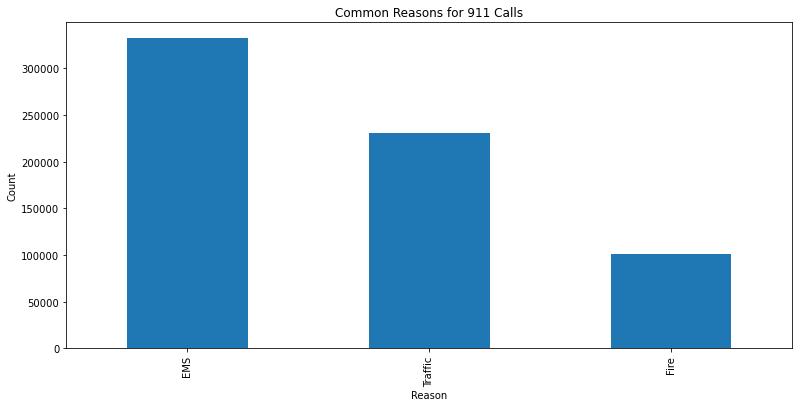

In [13]:
data.reason.value_counts().plot(kind='bar', title='Common Reasons for 911 Calls', xlabel='Reason', ylabel='Count')
# явный "лидер" - звонки в скорую помощь
# в целом это ожидаемо, т.к. пожары явление более редкое, и машины есть не у всех, вероятность обращения именно за
# медицинской помощью выше. К тому же при пожаре или ДТП скорую также часто вызывают, но обратная ситуация маловероятна. 

Будет интересно посмотреть как эти данные распределяются во времени. Допустим, мы хотим узнать, жители округа чаще набирают 911 в будние дни или в выходные. Либо когда происходит больше экстренных событий, днем или ночью. Немного преобразуем датасет, чтобы было можно ответить на подобные вопросы

In [56]:
data['timeStamp'] = pd.to_datetime(data['timeStamp'])


data['date'] = data['timeStamp'].apply(lambda time: time.date())
data['month'] = data['timeStamp'].apply(lambda time: time.month)
data['hour'] = data['timeStamp'].apply(lambda time: time.hour)
data['weekday'] = data['timeStamp'].apply(lambda time: time.dayofweek)

data.head()

lat        lng                                               desc  \
0  40.297876 -75.581294  REINDEER CT & DEAD END;  NEW HANOVER; Station ...   
1  40.258061 -75.264680  BRIAR PATH & WHITEMARSH LN;  HATFIELD TOWNSHIP...   
2  40.121182 -75.351975  HAWS AVE; NORRISTOWN; 2015-12-10 @ 14:39:21-St...   
3  40.116153 -75.343513  AIRY ST & SWEDE ST;  NORRISTOWN; Station 308A;...   
4  40.251492 -75.603350  CHERRYWOOD CT & DEAD END;  LOWER POTTSGROVE; S...   

       zip                    title           timeStamp                twp  \
0  19525.0   EMS: BACK PAINS/INJURY 2015-12-10 17:10:52        NEW HANOVER   
1  19446.0  EMS: DIABETIC EMERGENCY 2015-12-10 17:29:21  HATFIELD TOWNSHIP   
2  19401.0      Fire: GAS-ODOR/LEAK 2015-12-10 14:39:21         NORRISTOWN   
3  19401.0   EMS: CARDIAC EMERGENCY 2015-12-10 16:47:36         NORRISTOWN   
4      NaN           EMS: DIZZINESS 2015-12-10 16:56:52   LOWER POTTSGROVE   

                         addr reason        date  month  hour  weekday  
0      REINDEER CT & DEAD END    EMS  2015-12-10     12    17        3  
1  BRIAR PATH & WHITEMARSH LN    EMS  2015-12-10     12    17        3  
2                    HAWS AVE   Fire  2015-12-10     12    14        3  
3          AIRY ST & SWEDE ST    EMS  2015-12-10     12    16        3  
4    CHERRYWOOD CT & DEAD END    EMS  2015-12-10     12    16        3

In [15]:
weekday_calls = data.pivot_table(index='weekday', columns='reason', values='lat', aggfunc='size').sort_values('weekday')
weekday_calls

reason     EMS   Fire  Traffic
weekday                       
0        48720  14492    33495
1        48339  14297    35001
2        48011  15009    36091
3        47597  14605    36450
4        49334  15312    38249
5        46400  13886    29118
6        44079  12944    21800

In [16]:
# # дни недели представлены числами от 0 до 6, для красоты заменим цифровые значения названиями дней
weekday_dict= {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
weekday_calls.index= weekday_calls.index.map(weekday_dict)
weekday_calls

reason       EMS   Fire  Traffic
weekday                         
Monday     48720  14492    33495
Tuesday    48339  14297    35001
Wednesday  48011  15009    36091
Thursday   47597  14605    36450
Friday     49334  15312    38249
Saturday   46400  13886    29118
Sunday     44079  12944    21800

<AxesSubplot:title={'center':'911 calls per weekday'}, xlabel='weekday', ylabel='count'>

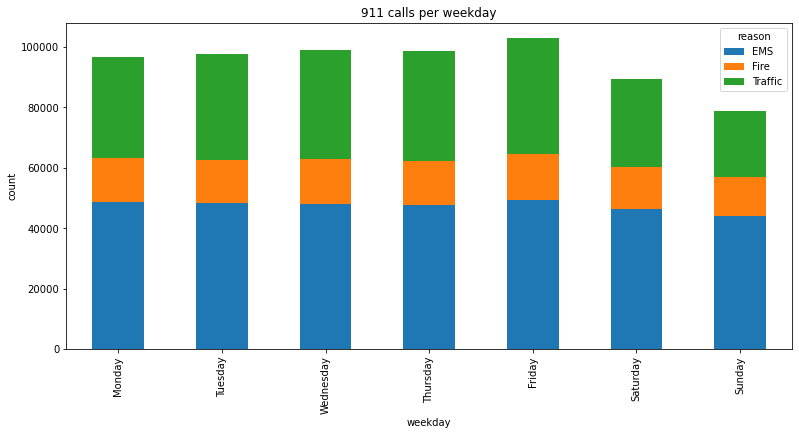

In [17]:
weekday_calls.plot(kind='bar', stacked=True, title='911 calls per weekday', xlabel='weekday', ylabel='count')

Получили, что в целом в буднии дни звонков больше, чем в выходные. Разница в течение понедельника-четверга не столь существенна, однако в пятницу явно больше всего звонков: прирост виден как у звонков о дорожных происшествиях, так и у звонков в скорую помощь. В выходные общий уровень снижается большей частью за счет сокращения звонков о дорожных происшествиях - на работу ехать не нужно, движение на улицах менее оживленное, меньше вероятность каких-либо происшествий. Звонков о пожарах к воскресенью так же становится немного меньше, но в целом по ним четкой связи с днями недели не прослеживается

In [18]:
daily_calls = data.pivot_table(index='hour', columns='reason', values='lat', aggfunc='size').sort_values('hour')
daily_calls

reason    EMS  Fire  Traffic
hour                        
0        8506  2119     3226
1        7600  1767     2365
2        7033  1535     2068
3        6341  1451     1685
4        6128  1408     1720
5        6893  1839     2939
6        8764  2418     6023
7       12119  3505    11333
8       15657  4453    13261
9       18591  5168    11707
10      20127  5463    10978
11      20021  5679    12368
12      19870  5699    14512
13      19235  5970    14579
14      18617  5953    15768
15      18341  6021    17897
16      18198  6152    18435
17      17955  6490    19661
18      16896  6379    14038
19      16278  5710    10439
20      14728  5075     8264
21      13348  4244     7051
22      11472  3346     5483
23       9762  2701     4404

<AxesSubplot:title={'center':'911 calls a day'}, xlabel='hour', ylabel='count'>

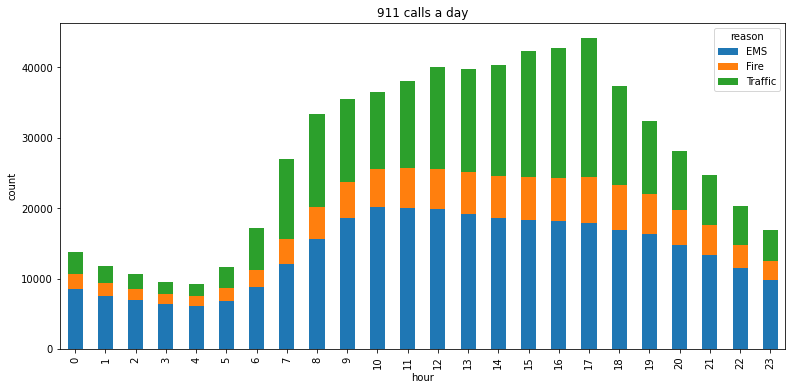

In [19]:
daily_calls.plot(kind='bar', stacked=True, title='911 calls a day', xlabel='hour', ylabel='count')

Здесь видим, что ночью звонков немного, большая часть - обращения в скорую помощь. Зато в 17 вечера, в момент максимального количества звонков, звонки в EMS и звонки о дорожных происшествиях сопоставимы. Конец рабочего дня, многие разъезжаются по домам с работы - отсюда пробки, ДТП и пр.  

Для того, чтобы посмотреть нагруженность по звонкам в разрезе 2х временных осей, например, дня недели и часа суток, можно построить тепловую карту

In [45]:
day_hour = data.groupby(['weekday', 'hour']).count()['lat'].unstack()
day_hour.index= day_hour.index.map(weekday_dict)
day_hour

hour         0     1     2     3     4     5     6     7     8     9   ...  \
weekday                                                                ...   
Monday     1893  1567  1366  1271  1336  1843  2675  4428  5502  5722  ...   
Tuesday    1719  1455  1322  1212  1245  1741  2782  4425  5633  5562  ...   
Wednesday  1662  1481  1258  1262  1128  1609  2667  4643  5465  5443  ...   
Thursday   1731  1407  1424  1234  1292  1774  2814  4431  5296  5411  ...   
Friday     1981  1632  1449  1296  1338  1638  2663  4138  5017  5288  ...   
Saturday   2442  2058  1879  1588  1449  1579  1879  2488  3457  4312  ...   
Sunday     2423  2132  1938  1614  1468  1487  1725  2404  3001  3728  ...   

hour         14    15    16    17    18    19    20    21    22    23  
weekday                                                                
Monday     5713  6289  6341  6407  5440  4488  3823  3252  2654  2069  
Tuesday    5923  6251  6494  6877  5625  4618  3843  3408  2706  2133  
Wednesday  6068  6532  6743  7061  5690  4684  4113  3530  2825  2204  
Thursday   6078  6493  6374  6933  5510  4701  4043  3490  2844  2351  
Friday     6392  7038  7064  7112  5667  5055  4373  3912  3421  2828  
Saturday   5420  5181  5210  5211  4979  4748  4125  3893  3224  2961  
Sunday     4744  4475  4559  4505  4402  4133  3747  3158  2627  2321  

[7 rows x 24 columns]

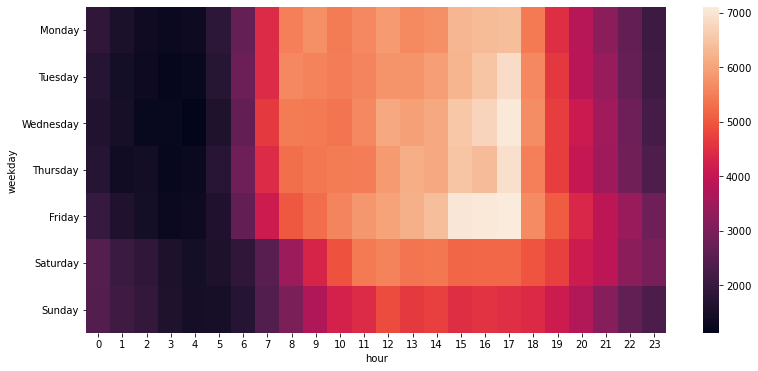

In [46]:
sns.heatmap(day_hour,cmap='rocket')

По этой визуализации заметно, что:
- распределение звонков похоже соответствует рамкам стандартного рабочего дня
- самое популярное время для звонков - окончание рабочего дня
- пятница - самый нагруженный день
- в выходные нет такой концентрации звонков как в будни
- в выходные суточный график звонков как будто сдвинут относительно будних дней на 2-3 часа позднее (очевидно, люди дольше бодрствуют - ночью больше звонков, и просыпаются позднее)

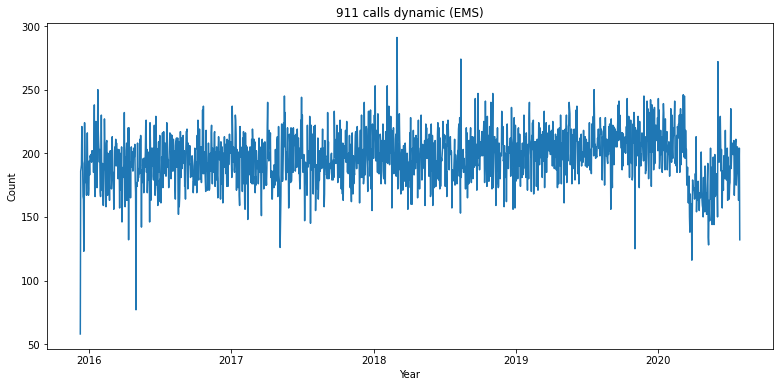

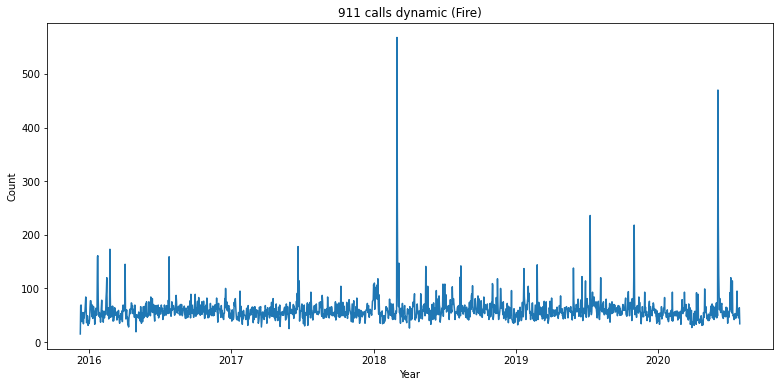

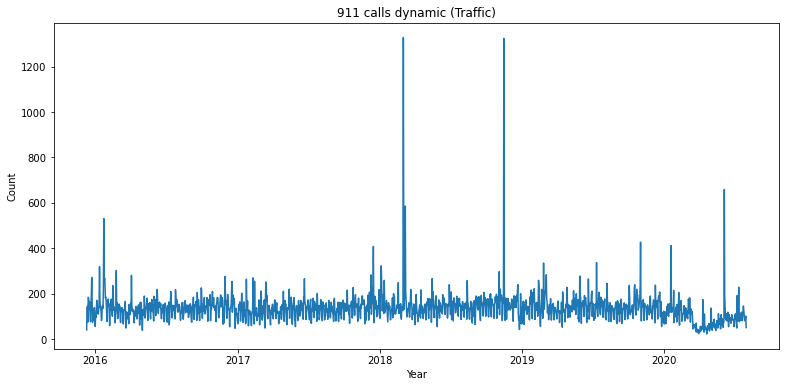

In [20]:
# посмотрим на динамику звонков в течение нескольких лет
date_df = data.pivot_table(index='date', columns='reason', values='lat', aggfunc='size').sort_values('date')
for col in date_df.columns:
    plt.plot(date_df.index, date_df[col])
    plt.title(f'911 calls dynamic ({col})')
    plt.xlabel('Year')
    plt.ylabel('Count') 

    plt.show()

В целом картина получилась не самой наглядной - масштаб в несколько лет делает графики менее читаемыми. Однако мы можем проследить, что есть некие пики на всех 3х графиках, приходящиеся примерно на одни и те же даты. Самый явный пример такого скачка - в начале 2018 года. 
Построим те же графики для 2018 года.

In [21]:
date_2018_df = date_df[(date_df.index>pd.Timestamp(2018,1,1)) & (date_df.index<pd.Timestamp(2018,12,31))]
date_2018_df.head()

reason      EMS  Fire  Traffic
date                          
2018-01-02  205    99      189
2018-01-03  230   110      217
2018-01-04  211    61      323
2018-01-05  253    81      278
2018-01-06  213    88      179

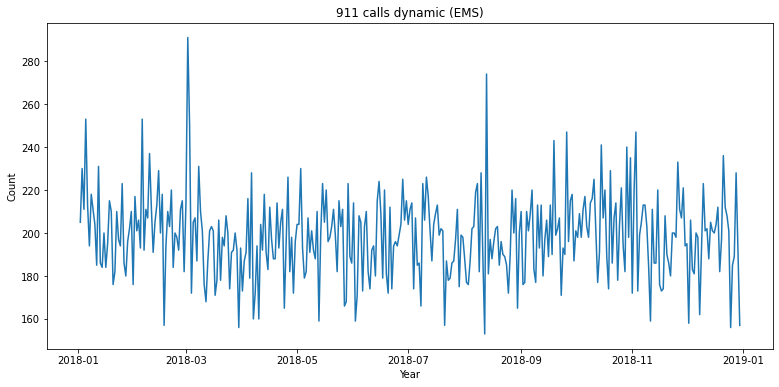

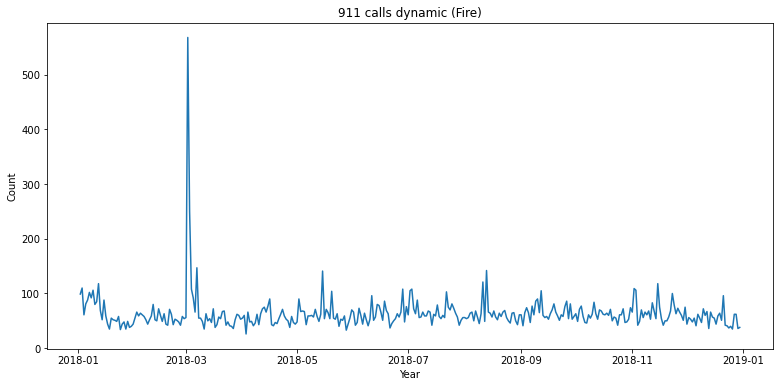

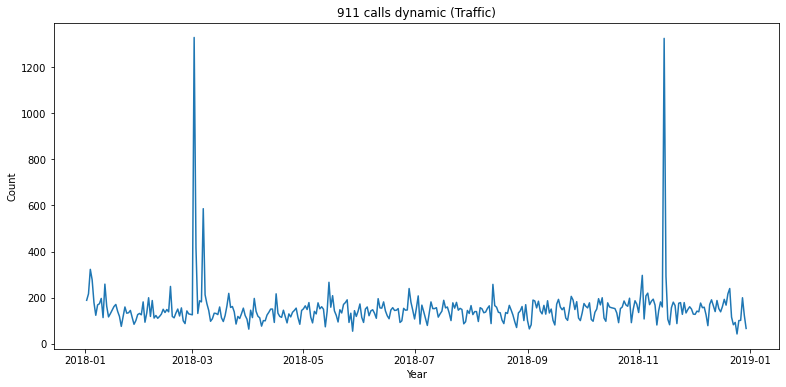

In [22]:
for col in date_2018_df.columns:
    plt.plot(date_2018_df.index, date_2018_df[col])
    plt.title(f'911 calls dynamic ({col})')
    plt.xlabel('Year')
    plt.ylabel('Count') 

    plt.show()

Пик звонков приходится на конец февраля - начало марта. Предполагаю, что в это время состоялся крупный пожар или серия пожаров, которые вызвали и дорожные происшествия, и увеличение количества обращений за медицинской помощью.  

Так же мы можем посмотреть на географические координаты, оценить их распределение. 

In [23]:
data[['lat', 'lng']].describe()

lat            lng
count  663229.000000  663229.000000
mean       40.158142     -75.300036
std         0.220639       1.673049
min         0.000000    -119.698206
25%        40.100344     -75.392751
50%        40.143821     -75.305143
75%        40.229008     -75.211812
max        51.335390      87.854975

Судя по всему координаты расположены достаточно кучно, но минимальные и максимальные значения далеки от мер центральной тенденции. Вероятно есть выбросы.

<AxesSubplot:xlabel='lng', ylabel='lat'>

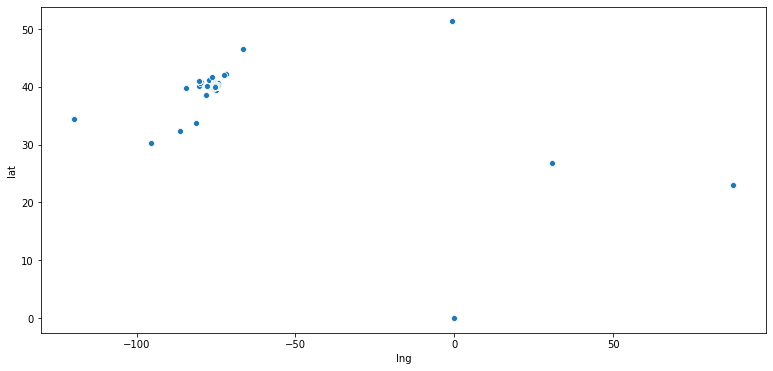

In [31]:
# посмотрим на взимосвязь широты и долготы
sns.scatterplot(x=data['lng'],y=data['lat'],data=data)


Действительно основное скопление точек около медианных значений, но есть отдельные значения, вынесенные довольно далеко.
Возможно, это звонки с мобильных, обслуживаемых операторами округа, совершенные в момент, когда владелец телефона вне округа Монтгомери.


In [7]:
def get_bounds(column):
    q1 = column.quantile(0.25)
    q3 = column.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr) 
    upper_bound = q3 + (1.5 * iqr)
    return lower_bound, upper_bound

In [8]:
lower_lat, upper_lat = get_bounds(data['lat'])
lower_lng, upper_lng = get_bounds(data['lng'])


remove_outliers = data[(data.lat.between(lower_lat, upper_lat, inclusive=True))&
                      (data.lng.between(lower_lng, upper_lng, inclusive=True))]
remove_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 656565 entries, 0 to 663521
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   lat        656565 non-null  float64
 1   lng        656565 non-null  float64
 2   desc       656565 non-null  object 
 3   zip        577196 non-null  float64
 4   title      656565 non-null  object 
 5   timeStamp  656565 non-null  object 
 6   twp        656280 non-null  object 
 7   addr       656565 non-null  object 
dtypes: float64(3), object(5)
memory usage: 45.1+ MB


<AxesSubplot:xlabel='lng', ylabel='lat'>

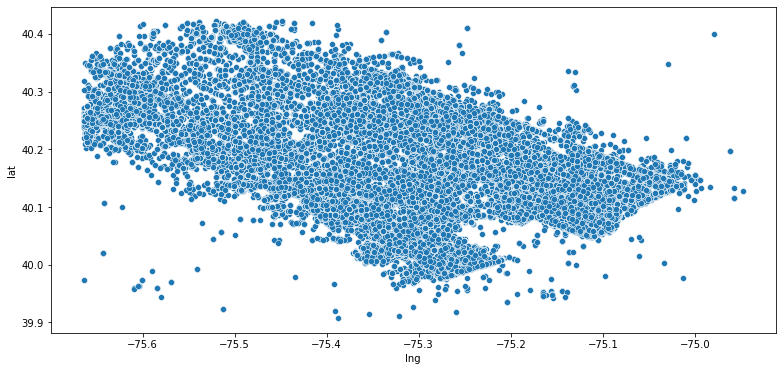

In [9]:
# посмотрим на взимосвязь широты и долготы без выбросов
sns.scatterplot(x=remove_outliers['lng'],y=remove_outliers['lat'],data=remove_outliers)

выглядит похоже на форму округа Монтгомери (на рисунке - красная заливка). Видимо, звонки поступают относительно равномерно со всех территорий округа. 


<img src="Images/Montgomery_County.png">

In [10]:
import folium as fo

In [11]:
# для наглядности можно даже нанести геокоординаты на реальную карту
Map=fo.Map([remove_outliers.lat.median(), remove_outliers.lng.median()],zoom_start=10)
# чтобы выполнялось быстрее и не было загромождения точек на карте, возьму небольшую рандомную часть   
random_index=np.random.choice(remove_outliers.index, 6000) 
for ind in random_index:
    lat=remove_outliers.loc[ind,'lat']
    long=remove_outliers.loc[ind,'lng']
    fo.CircleMarker([lat,long],radius=1, opacity=0.5).add_to(Map)
Map
 

Таким образом проведен базовый исследовательский анализ данных: исследованы основные категории причин звонков, динамика звонков во времени, географическое распределение координат с мест вызовов